In [29]:
import glob
import aqdefreader as aqdr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime as dt

In [22]:
def load_dfq(filepath):
    """Loads a DFQ file into a pandas DataFrame.
    Args:
        filepath (str): The path to the DFQ file.
    Returns:
        pandas.DataFrame: A pandas DataFrame containing the data from the DFQ file.
        Returns None if the file does not exist or if an error occurs during loading.
    """

    dfq_data: aqdr.DfqFile = aqdr.read_dfq_file(filepath)
    cc_df = aqdr.create_column_dataframe(dfq_data)
    return cc_df

def load_data(data_folder_path: str) -> pd.DataFrame:
    data_file_paths = glob.glob(f"{data_folder_path}/*.dfq")
    data_file_paths = sorted(data_file_paths)

    dfq_data_list = []
    for idx, path in enumerate(data_file_paths):
        if idx % 100 == 0:
            print(f"Processing file {idx+1}/{len(data_file_paths)}: {path}")
        try:
            data = load_dfq(path)
            dfq_data_list.append(data)   
            # print(dfq_data_list[-1].head())
        
        except Exception as e:
            print(f"Error reading file {path}: {e}")
            continue
    
    return data
    combined_df = pd.concat(dfq_data_list, ignore_index=True)
    print(combined_df.head())
    
    return combined_df


In [ ]:
# Load the data
inners_path = "D:/New folder"
inners_df = load_data(inners_path)

In [52]:
def calculate_bollinger_bands(data: pd.DataFrame, sigma_factor: float = 3, window: int = 50) -> pd.DataFrame:
    sma = data.rolling(window).mean()
    std_dev = data.rolling(window).std()
    bollinger = pd.DataFrame()
    bollinger['Upper'] = sma + sigma_factor * std_dev
    bollinger['Lower'] = sma - sigma_factor * std_dev
    return bollinger

def plot_data(parts_df: pd.DataFrame, sigma_factor: float, window:int = 50, start_at: int = 0, 
              legend: bool = True, start_date:dt = dt(2020, 1, 1), end_date:dt = dt.today()) -> None:
    # cut dates outside of the start and end date
    parts_df = parts_df[(parts_df.index >= start_date) & (parts_df.index <= end_date)]

    probe_cols = [f"Probe {i}" for i in range(1, 7)]
    track_cols = [f"Track {i}-{i+3}" for i in range(1, 4)]
    parts_df = parts_df[round(start_at*len(parts_df)):]

    def remove_outliers(data):
        Q1 = data.quantile(0.5)
        Q3 = data.quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 5 * IQR
        upper_bound = Q3 + 5 * IQR
        return data[(data >= lower_bound) & (data <= upper_bound)]

    # --- Probe Data Plotting and Statistics ---
    fig, axes = plt.subplots(4, 3, figsize=(15, 15))

    probe_stats = {}
    for i, probe in enumerate(probe_cols):
        raw_data = parts_df[probe].dropna()
        data = remove_outliers(raw_data)  # Remove outliers for statistics and plotting
        mean = round(stats.describe(data).mean, 3)
        sigma_limits = round(sigma_factor * stats.describe(data).variance ** 0.5, 3)
        upper_limit = round(mean + sigma_limits, 3)
        lower_limit = round(mean - sigma_limits, 3)
        rolling_mean = data.rolling(window).mean()
        bollinger = calculate_bollinger_bands(data, sigma_factor, window)
        x_pos = int(i/3)*2
        y_pos = i%3

        # Line plot
        axes[x_pos, y_pos].plot(data, label=None)  # Using actual index values
        axes[x_pos, y_pos].axhline(y=upper_limit, color='r', linestyle='--', label=f'{sigma_factor} σ Limits ({mean:.3f}±{sigma_limits:.3f})')
        axes[x_pos, y_pos].axhline(y=lower_limit, color='r', linestyle='--')
        axes[x_pos, y_pos].plot(rolling_mean, color='black', label=f'Rolling Mean ({window})')  # Using actual index values
        axes[x_pos, y_pos].plot(bollinger['Upper'], color='orange', label=f'{sigma_factor} σ Bollinger Bands ({window})')  # Using actual index values
        axes[x_pos, y_pos].plot(bollinger['Lower'], color='orange')  # Using actual index values
        axes[x_pos, y_pos].set_title(f"{probe}")
        if legend:
            axes[x_pos, y_pos].legend()
        axes[x_pos, y_pos].grid(True)

        # Histogram
        axes[x_pos+1, y_pos].hist(data, bins=20, edgecolor='black')
        axes[x_pos+1, y_pos].axvline(x=upper_limit, color='r', linestyle='--', label=f'Upper Limit ({upper_limit:.4f})')
        axes[x_pos+1, y_pos].axvline(x=lower_limit, color='r', linestyle='--', label=f'Lower Limit ({lower_limit:.4f})')
        axes[x_pos+1, y_pos].set_title(f'{probe} Histogram')
        axes[x_pos+1, y_pos].set_xlabel('Value')
        axes[x_pos+1, y_pos].set_ylabel('Frequency')

        probe_stats[probe] = {'Mean': mean, f'{sigma_factor}x Sigma': sigma_limits,
                             'Upper Limit': upper_limit, 'Lower Limit': lower_limit,
                             'Outliers Removed': len(raw_data) - len(data)}

    fig.suptitle("Probe Measurements", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for ax in axes.flat:  # This will get all subplots
        ax.tick_params(axis='x', labelrotation=45)
    plt.show()

    
    probe_stats_df = pd.DataFrame(probe_stats).transpose()
    print(probe_stats_df)

    # --- Track Data Plotting and Statistics ---
    fig, axes = plt.subplots(2, len(track_cols), figsize=(15, 10), sharey='row')

    track_stats = {}
    for i, track in enumerate(track_cols):
        raw_data = parts_df[track].dropna()
        data = remove_outliers(raw_data)  # Remove outliers for statistics and plotting
        mean = round(stats.describe(data).mean, 3)
        sigma_limits = round(sigma_factor * stats.describe(data).variance ** 0.5, 3)
        upper_limit = round(mean + sigma_limits, 3)
        lower_limit = round(mean - sigma_limits, 3)
        rolling_mean = data.rolling(window).mean()
        bollinger = calculate_bollinger_bands(data, sigma_factor, window)

        # Line plot
        axes[0, i].plot(data)  # Using actual index values
        axes[0, i].axhline(y=upper_limit, color='r', linestyle='--')
        axes[0, i].axhline(y=lower_limit, color='r', linestyle='--', label=f'{sigma_factor} σ Limits ({mean:.3f}±{sigma_limits:.3f})')
        axes[0, i].plot(rolling_mean, color='black', label=f'Rolling Mean ({window})')  # Using actual index values
        axes[0, i].plot(bollinger['Upper'], color='orange', label=f'{sigma_factor} σ Bollinger Bands ({window})')  # Using actual index values
        axes[0, i].plot(bollinger['Lower'], color='orange')  # Using actual index values


        axes[0, i].set_title(f"{track}")
        if legend:
            axes[0, i].legend()
        axes[0, i].grid(True)

        # Histogram
        axes[1, i].hist(data, bins=20, edgecolor='black')
        axes[1, i].axvline(x=upper_limit, color='r', linestyle='--')
        axes[1, i].axvline(x=lower_limit, color='r', linestyle='--')
        axes[1, i].set_title(f'{track} Histogram')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Frequency')

        track_stats[track] = {'Mean': mean, f'{sigma_factor}x Sigma': sigma_limits,
                            'Upper Limit': upper_limit, 'Lower Limit': lower_limit,
                            'Outliers Removed': len(raw_data) - len(data)}

    fig.suptitle(f"Track Data with {sigma_factor} Sigma Limits", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])    
    for ax in axes.flat:  # This will get all subplots
        ax.tick_params(axis='x', labelrotation=45)
    plt.show()

    track_stats_df = pd.DataFrame(track_stats).transpose()
    print(track_stats_df)



In [ ]:
# Plot the data
plot_data(inners_df, sigma_factor=2.3, window=5000, start_at=0, legend=True)


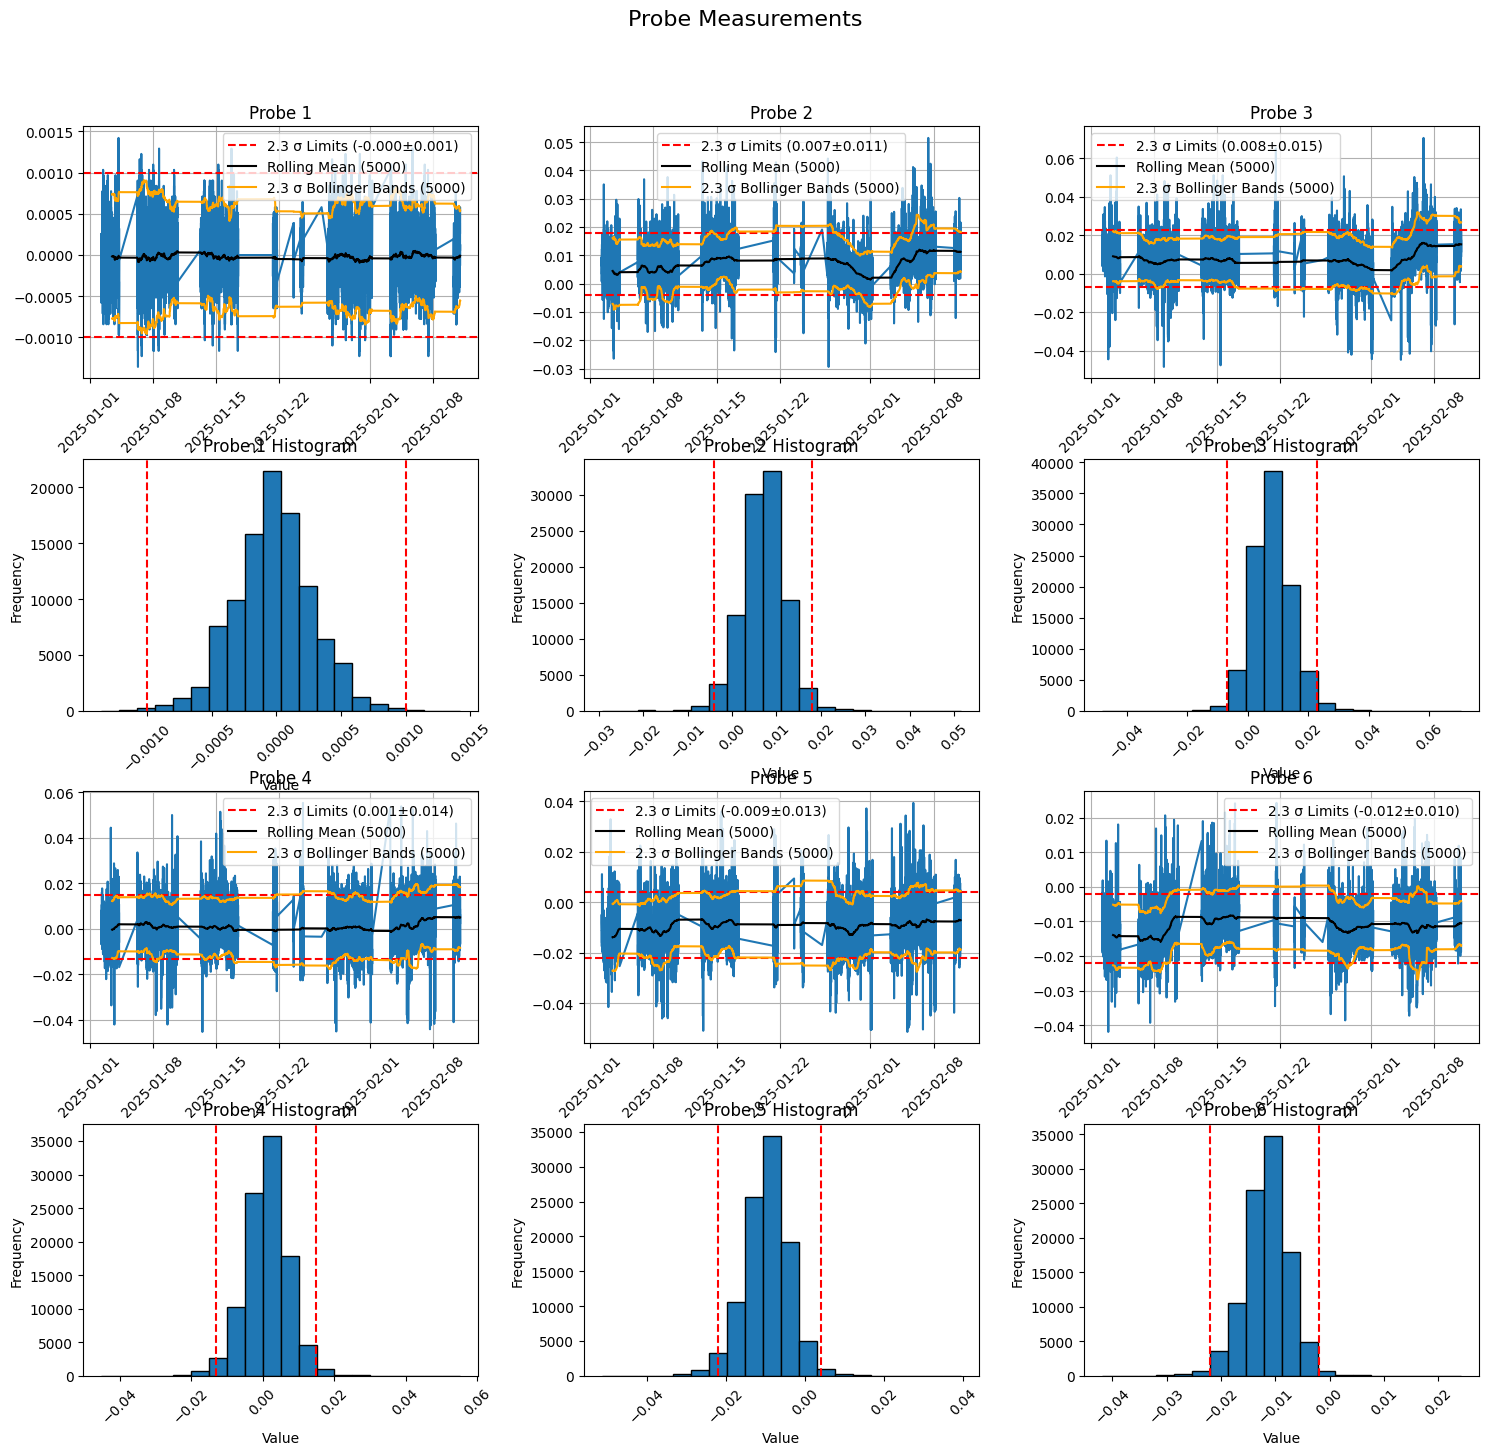

          Mean  2.3x Sigma  Upper Limit  Lower Limit  Outliers Removed
Probe 1 -0.000       0.001        0.001       -0.001               1.0
Probe 2  0.007       0.011        0.018       -0.004              19.0
Probe 3  0.008       0.015        0.023       -0.007               8.0
Probe 4  0.001       0.014        0.015       -0.013              48.0
Probe 5 -0.009       0.013        0.004       -0.022              22.0
Probe 6 -0.012       0.010       -0.002       -0.022              29.0


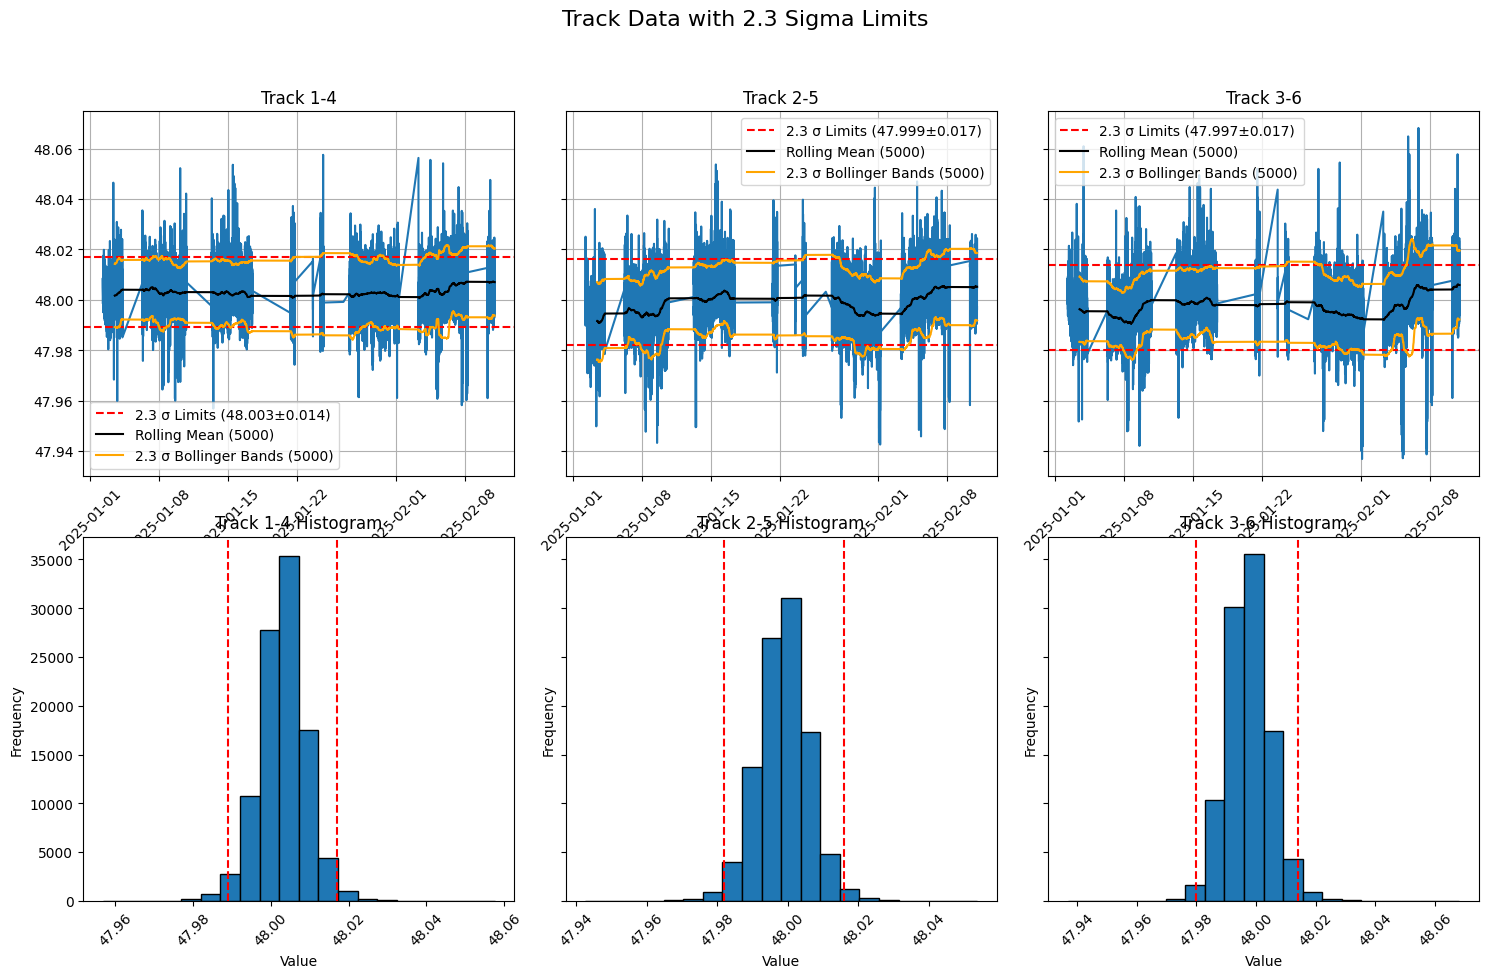

             Mean  2.3x Sigma  Upper Limit  Lower Limit  Outliers Removed
Track 1-4  48.003       0.014       48.017       47.989              49.0
Track 2-5  47.999       0.017       48.016       47.982              17.0
Track 3-6  47.997       0.017       48.014       47.980              15.0


In [55]:
plot_data(inners_df, sigma_factor=2.3, window=5000, start_at=0, legend=True, start_date=dt(2025,1,1), end_date=dt(2025,2,11))

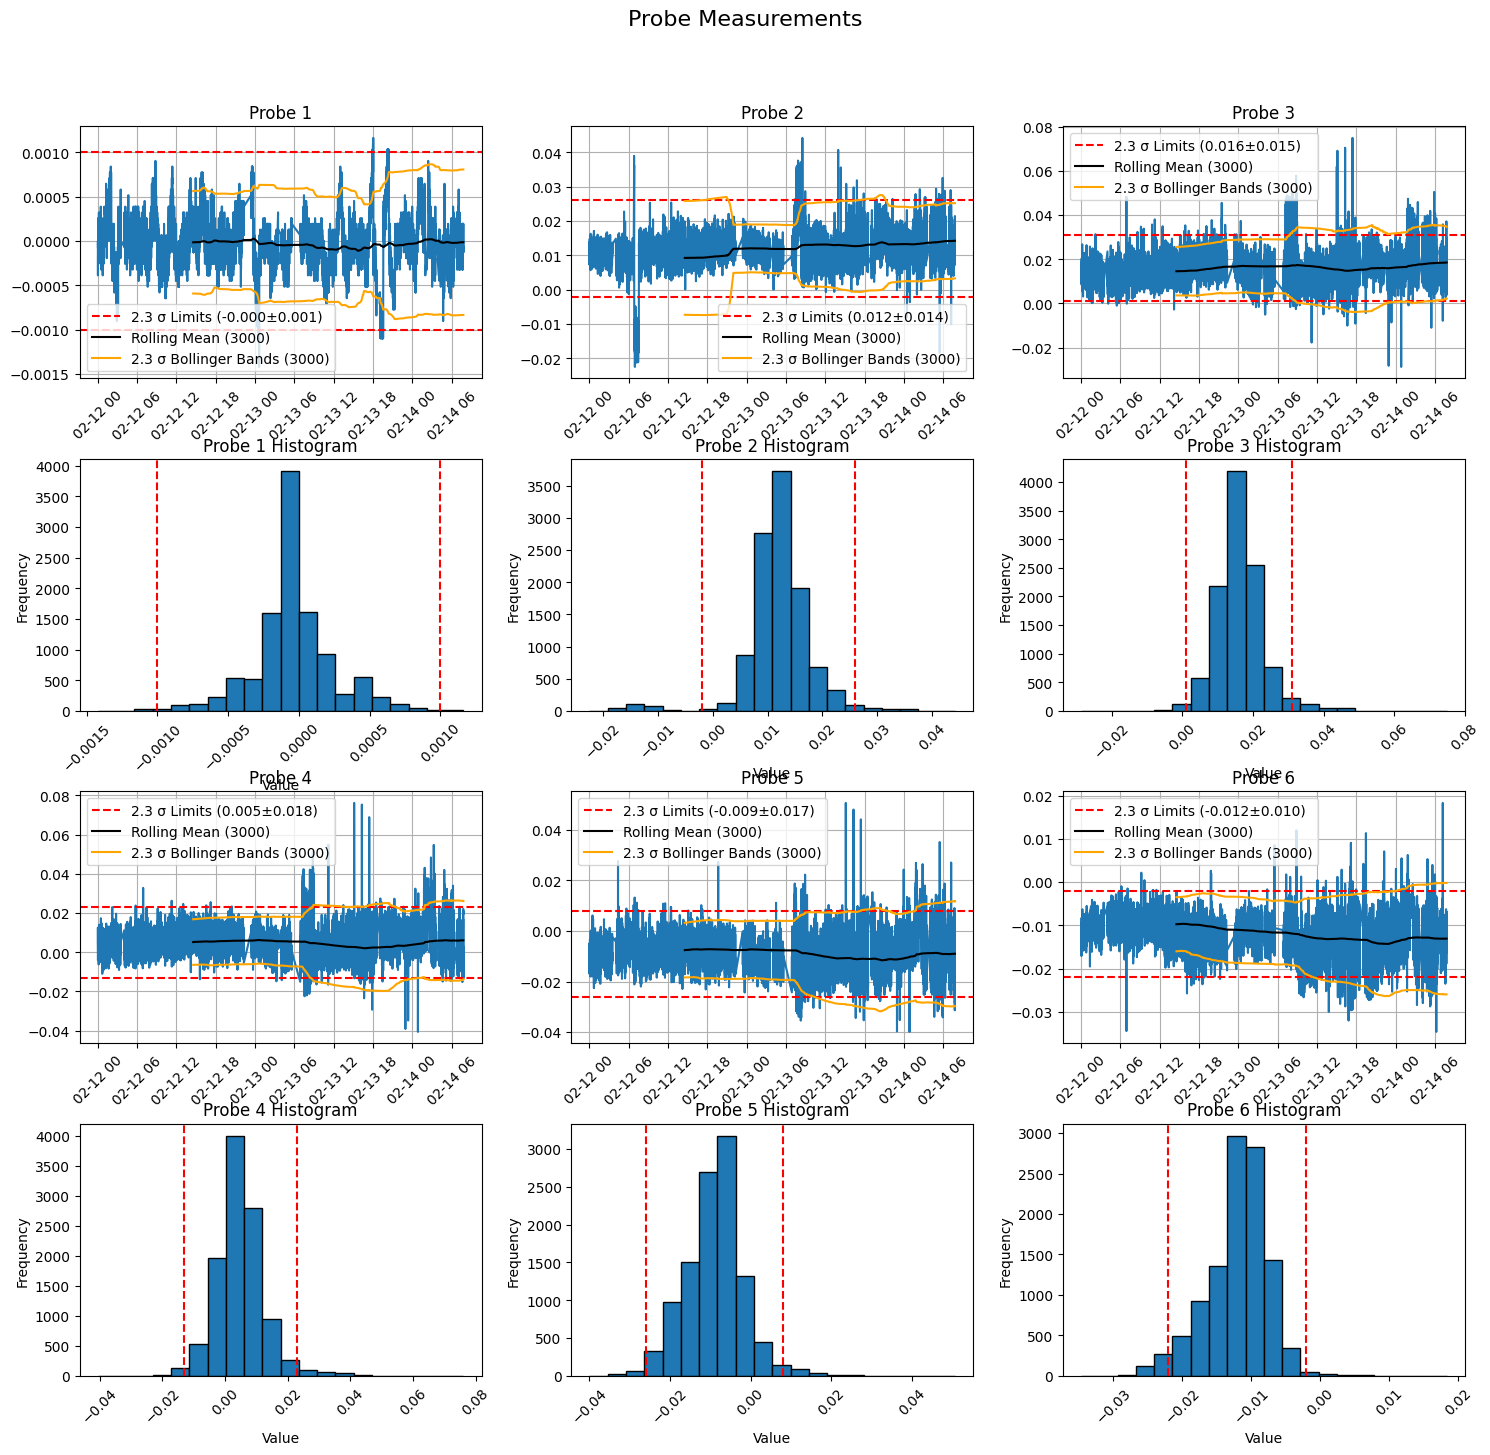

          Mean  2.3x Sigma  Upper Limit  Lower Limit  Outliers Removed
Probe 1 -0.000       0.001        0.001       -0.001               0.0
Probe 2  0.012       0.014        0.026       -0.002               1.0
Probe 3  0.016       0.015        0.031        0.001               0.0
Probe 4  0.005       0.018        0.023       -0.013               0.0
Probe 5 -0.009       0.017        0.008       -0.026               1.0
Probe 6 -0.012       0.010       -0.002       -0.022               4.0


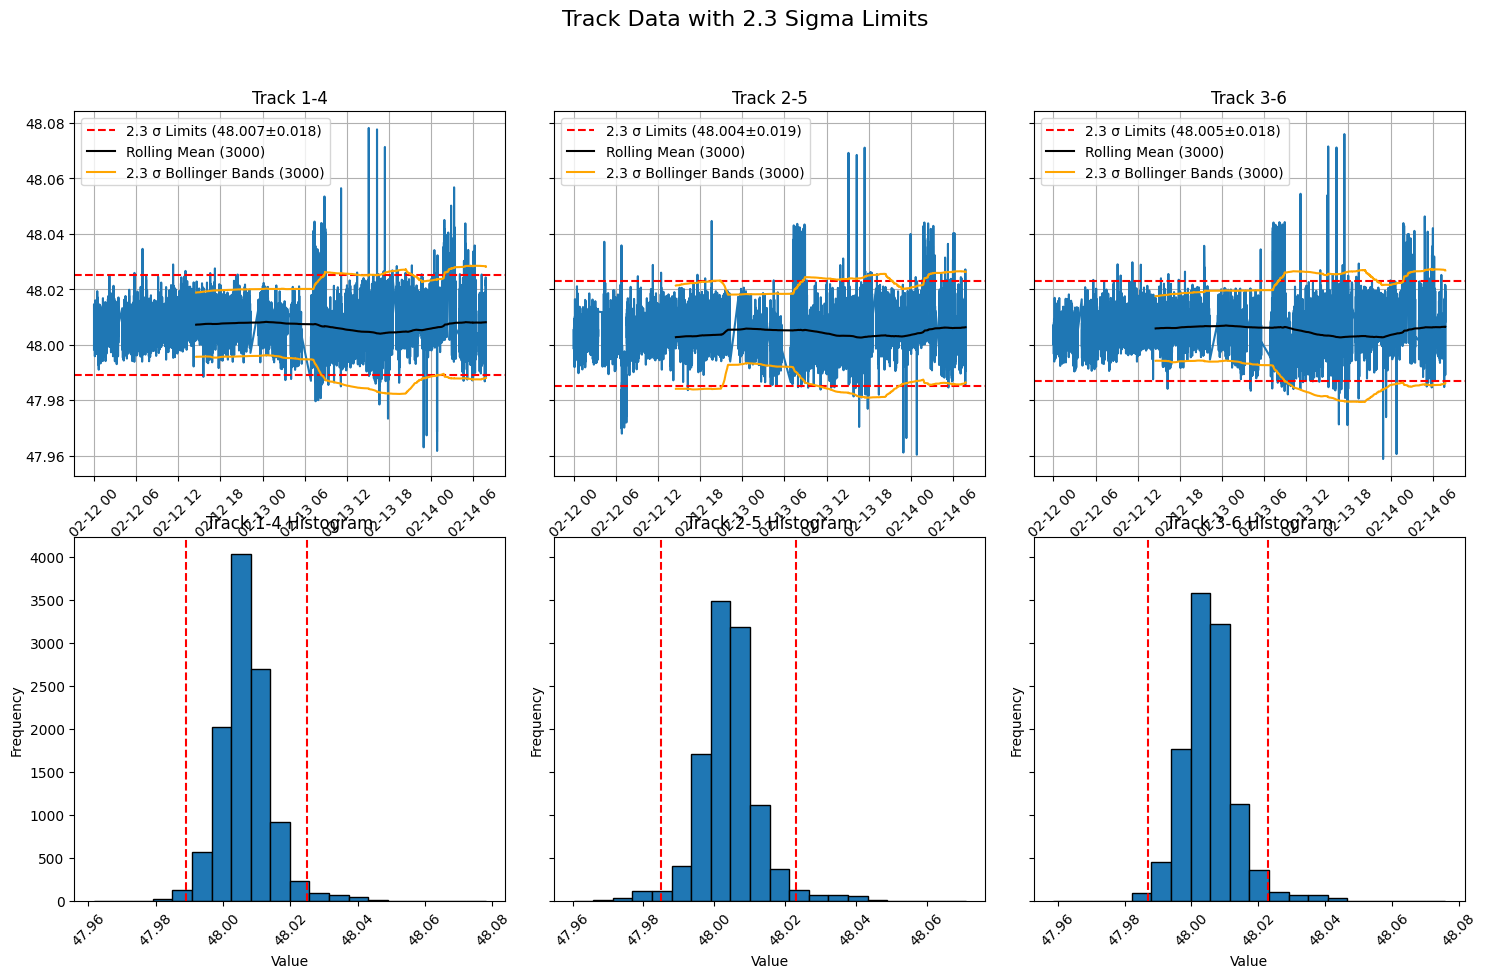

             Mean  2.3x Sigma  Upper Limit  Lower Limit  Outliers Removed
Track 1-4  48.007       0.018       48.025       47.989               0.0
Track 2-5  48.004       0.019       48.023       47.985               0.0
Track 3-6  48.005       0.018       48.023       47.987               1.0


In [54]:
plot_data(inners_df, sigma_factor=2.3, window=3000, start_at=0, legend=True, start_date=dt(2025,2,12))